In [60]:
import pandas as pd
import zipfile
import os

zip_path = 'admission_predict.zip'
extract_dir = 'admission_data'
csv_subdir = os.path.join(extract_dir, 'admission_predict')


os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

csv_files = [f for f in os.listdir(csv_subdir) if f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError(f"No CSV file found in the expected subdirectory: {csv_subdir}")
csv_filename = csv_files[0]
csv_path = os.path.join(csv_subdir, csv_filename)

df = pd.read_csv(csv_path)

display(df.head())

print(df.head(3))

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


   Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  \
0           1        337          118                  4  4.5   4.5  9.65   
1           2        324          107                  4  4.0   4.5  8.87   
2           3        316          104                  3  3.0   3.5  8.00   

   Research  Chance of Admit   
0         1              0.92  
1         1              0.76  
2         1              0.72  


In [61]:
print(df.isnull().sum())

print("Eksik değerli satırlar:")
print(df[df.isnull().any(axis=1)])

df = df.dropna()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64
Eksik değerli satırlar:
Empty DataFrame
Columns: [Serial No., GRE Score, TOEFL Score, University Rating, SOP, LOR , CGPA, Research, Chance of Admit ]
Index: []


In [64]:
X = df[['GRE Score', 'TOEFL Score', 'University Rating', 'CGPA', 'SOP']]
y = df['Chance of Admit '] # Corrected column name with trailing space

In [66]:
df['Chance of Admit'] = df['Chance of Admit '].apply(lambda x: 1 if x >= 0.75 else 0)

print(df['Chance of Admit'].value_counts())

Chance of Admit
0    220
1    180
Name: count, dtype: int64


In [67]:

from sklearn.model_selection import train_test_split

X = df.drop('Chance of Admit' , axis=1)
y = df['Chance of Admit']

X_train , X_test , y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Eğitim seti boyutu:", X_train.shape, y_train.shape)
print("Test seti boyutu:", X_test.shape, y_test.shape)

Eğitim seti boyutu: (320, 9) (320,)
Test seti boyutu: (80, 9) (80,)


In [68]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("Tamamlandı ")

Tamamlandı 


In [69]:

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)


model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [70]:

model = LogisticRegression(
    class_weight='balanced',
    random_state=42,
    max_iter=1000,
    solver='lbfgs'
)

model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [71]:

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
print("İlk 3 tahmin (sınıf):", y_pred[:3])
print("İlk 3 tahmin (olasılık):", y_pred_proba[:3])


İlk 3 tahmin (sınıf): [0 1 1]
İlk 3 tahmin (olasılık): [0.01560566 0.83203039 0.70697467]


In [72]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)

print(f"Model Doğruluk Oranı: {accuracy:.2f} (%{accuracy*100:.0f})")

Model Doğruluk Oranı: 0.96 (%96)


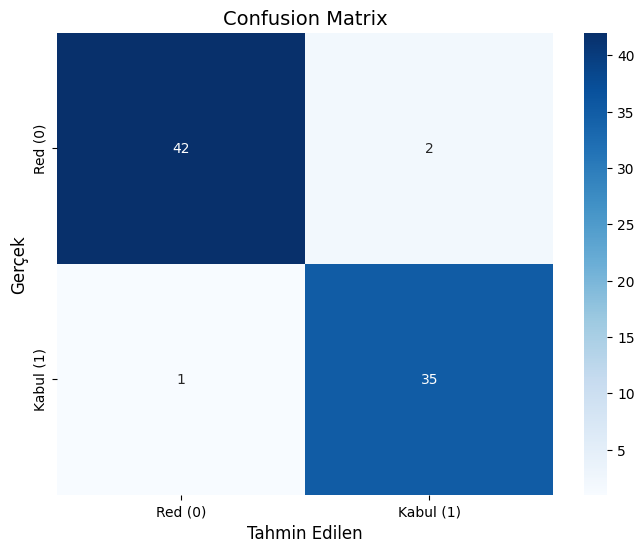

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Red (0)', 'Kabul (1)'],
            yticklabels=['Red (0)', 'Kabul (1)'])
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Tahmin Edilen', fontsize=12)
plt.ylabel('Gerçek', fontsize=12)
plt.show()

In [74]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, target_names=['Red (0)', 'Kabul (1)'])
print("=== Classification Report ===")
print(report)


=== Classification Report ===
              precision    recall  f1-score   support

     Red (0)       0.98      0.95      0.97        44
   Kabul (1)       0.95      0.97      0.96        36

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80



In [75]:

results = pd.DataFrame({
    'Gerçek Değer': y_test,
    'Tahmin Olasılığı': y_pred_proba,
    'Tahmin Sınıfı': y_pred
})

results_sorted = results.sort_values(by='Tahmin Olasılığı', ascending=False)

print("En yüksek kabul olasılığına sahip 10 örnek:")
print(results_sorted.head(10))

En yüksek kabul olasılığına sahip 10 örnek:
     Gerçek Değer  Tahmin Olasılığı  Tahmin Sınıfı
202             1          0.999990              1
384             1          0.999975              1
130             1          0.999971              1
212             1          0.999971              1
120             1          0.999960              1
25              1          0.999952              1
193             1          0.999952              1
214             1          0.999925              1
397             1          0.999802              1
276             1          0.999659              1


In [76]:
print("Nihai Ağırlıklar (W):", model.coef_)
print("Nihai Bias (b):", model.intercept_)

Nihai Ağırlıklar (W): [[ 0.01325288 -0.11351793  0.25548972  0.35184486  0.38530844  0.21036976
   0.82734665  0.04663084  5.00051109]]
Nihai Bias (b): [-0.64481061]


In [77]:
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

for thresh in thresholds:
    print(f"\n=== Eşik Değeri: {thresh} ===")

    y_pred_thresh = (y_pred_proba >= thresh).astype(int)

    print(classification_report(y_test, y_pred_thresh))


=== Eşik Değeri: 0.5 ===
              precision    recall  f1-score   support

           0       0.98      0.95      0.97        44
           1       0.95      0.97      0.96        36

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80


=== Eşik Değeri: 0.6 ===
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        44
           1       0.94      0.94      0.94        36

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80


=== Eşik Değeri: 0.7 ===
              precision    recall  f1-score   support

           0       0.91      0.98      0.95        44
           1       0.97      0.89      0.93        36

    accuracy                           0.94        80
   macro avg       0.94      0.93      0.94       

In [78]:

if 'Admit_Binary' not in df.columns:
    df['Admit_Binary'] = df['Chance of Admit'].apply(lambda x: 1 if x >= 0.75 else 0)


X = df.drop(['Chance of Admit', 'Admit_Binary'], axis=1, errors='ignore')
y = df['Admit_Binary']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_scaled, y)

df['Prediction_Probability'] = model.predict_proba(X_scaled)[:, 1]

top_20_students = df.sort_values('Prediction_Probability', ascending=False).head(20)


if 'Name' in df.columns:
    print("\nBURS VERİLECEK ÖĞRENCİ LİSTESİ (İsim Sıralı):")
    for i, (_, row) in enumerate(top_20_students.iterrows(), 1):
        print(f"{i}. {row['Name']} - Kabul Olasılığı: {row['Prediction_Probability']:.4f}")
else:
    print("\nBURS VERİLECEK ÖĞRENCİ LİSTESİ (ID Sıralı):")
    for i, (_, row) in enumerate(top_20_students.iterrows(), 1):
        print(f"{i}. ID: {row['Serial No.']} - Kabul Olasılığı: {row['Prediction_Probability']:.4f}")

print("\nDETAYLI BİLGİLER:")
print(top_20_students[['Serial No.', 'GRE Score', 'TOEFL Score', 'CGPA', 'Prediction_Probability']].to_markdown(index=False))


BURS VERİLECEK ÖĞRENCİ LİSTESİ (ID Sıralı):
1. ID: 203.0 - Kabul Olasılığı: 1.0000
2. ID: 204.0 - Kabul Olasılığı: 1.0000
3. ID: 144.0 - Kabul Olasılığı: 1.0000
4. ID: 386.0 - Kabul Olasılığı: 1.0000
5. ID: 214.0 - Kabul Olasılığı: 1.0000
6. ID: 25.0 - Kabul Olasılığı: 1.0000
7. ID: 385.0 - Kabul Olasılığı: 1.0000
8. ID: 72.0 - Kabul Olasılığı: 1.0000
9. ID: 82.0 - Kabul Olasılığı: 1.0000
10. ID: 213.0 - Kabul Olasılığı: 1.0000
11. ID: 131.0 - Kabul Olasılığı: 1.0000
12. ID: 24.0 - Kabul Olasılığı: 1.0000
13. ID: 149.0 - Kabul Olasılığı: 1.0000
14. ID: 400.0 - Kabul Olasılığı: 1.0000
15. ID: 373.0 - Kabul Olasılığı: 1.0000
16. ID: 71.0 - Kabul Olasılığı: 1.0000
17. ID: 338.0 - Kabul Olasılığı: 1.0000
18. ID: 121.0 - Kabul Olasılığı: 1.0000
19. ID: 26.0 - Kabul Olasılığı: 1.0000
20. ID: 194.0 - Kabul Olasılığı: 1.0000

DETAYLI BİLGİLER:
|   Serial No. |   GRE Score |   TOEFL Score |   CGPA |   Prediction_Probability |
|-------------:|------------:|--------------:|-------:|-------------

In [79]:
from google.colab import files
uploaded = files.upload()

Saving admission_predict.zip to admission_predict (2).zip


In [57]:
import os
print(os.listdir('admission_data'))

['admission_predict']
